In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

First Let's load the data

In [3]:
conf = pd.read_csv('./../confusion_matrix.csv')

conf.head()

Actual                   Predicted  _defaultColorIndex  \
0  grassland and others        grassland and others                   4   
1  grassland and others                      forest                   4   
2  grassland and others               sparse forest                   4   
3  grassland and others                       water                   4   
4  grassland and others  glacier and permanent snow                   4   

         id  nPredictions            name  
0  j922jv0q      32390830  pspnet/focal/0  
1  j922jv0q        208194  pspnet/focal/0  
2  j922jv0q        127016  pspnet/focal/0  
3  j922jv0q         14199  pspnet/focal/0  
4  j922jv0q          5372  pspnet/focal/0

In [4]:
print(len(conf)/4)

128.0


So we need to change this into several different dataframes with regards to the name of the test that was done.

In [5]:
print(conf.name.unique())
names = ['pspnet/dice+ce', 'pspnet/focal/2', 'pspnet/ce', 'pspnet/dice']
dice_ce = conf.loc[conf.name == names[0]].copy()
focal = conf.loc[conf.name == names[1]].copy()
ce = conf.loc[conf.name == names[2]].copy()
dice = conf.loc[conf.name == names[3]].copy()

dfs = [dice_ce, focal, ce, dice]

['pspnet/focal/0' 'pspnet/focal/1' 'pspnet/focal/2' 'pspnet/focal/3'
 'pspnet/focal/5' 'pspnet/ce' 'pspnet/dice' 'pspnet/dice+ce']


Now for each dataframe we need to turn it into a confusion matrix layout where the columns are predictions and the rows are actual

In [6]:
print(conf.Actual.unique())
classes = ['grassland and others', 'forest', 'sparse forest', 'water',
 'glacier and permanent snow', 'sparse rocks', 'scree', 'rocks']

['grassland and others' 'forest' 'sparse forest' 'water'
 'glacier and permanent snow' 'sparse rocks' 'scree' 'rocks']


In [7]:
datas = []

for df in dfs:
    data = []
    for cls_actual in classes:
        row = {
            'actual':cls_actual,
            'grassland and others':0,
            'forest':0,
            'sparse forest':0,
            'water':0,
            'glacier and permanent snow':0,
            'sparse rocks':0,
            'scree':0, 
            'rocks':0
        }
        for cls_predicted in classes:
            row[cls_predicted] = df.loc[(df.Actual == cls_actual)&(df.Predicted == cls_predicted)].nPredictions.values[0]
        data.append(row)
    datas.append(data)

dice_ce_mtrx, focal_mtrx, ce_mtrx, dice_mtrx = pd.DataFrame(datas[0]),pd.DataFrame(datas[1]),pd.DataFrame(datas[2]),pd.DataFrame(datas[3])
matricies = [dice_ce_mtrx, focal_mtrx, ce_mtrx, dice_mtrx]

for df in matricies:
    df.set_index('actual', inplace=True)
#     df['total'] = df.sum(axis=1)
#     for col in df.drop('total', axis=1).columns:
#         df[col] = (df[col]/df.total)*100
#     df.drop('total', axis=1, inplace=True)


In [8]:
dice_ce_mtrx.sum(axis=None)

grassland and others          49143800
forest                         9031983
sparse forest                  4228329
water                          3647191
glacier and permanent snow     9396558
sparse rocks                   5058895
scree                         46990537
rocks                         19662707
dtype: int64

In [9]:
names = ['Dice and Cross Entropy', 'Focal', 'Cross Entropy', 'Dice']
classes = ['grassland and others', 'forest', 'sparse forest', 'water',
 'glacier and permanent snow', 'sparse rocks', 'scree', 'rocks']
# for score in ['Accuracy', 'Precision', 'Recall', 'F1']:
data = []
data_2 =[]

for df, name in zip(matricies, names):
    accuracy_count = 0
    for cls in classes:
        recall = df.loc[cls][cls]/df.loc[cls].sum()
        precision = df.loc[cls][cls]/df[cls].sum()
        F1 = 2*precision*recall/(precision+recall)
        row={
            'model': name,
            'class': cls,
            'Recall': recall,
            'Precision': precision,
            'F1': F1
        }
        data.append(row)
        accuracy_count += df.loc[cls][cls]
    row_2 = {
        'model': name,
        'Overall Accuracy':accuracy_count/df.sum().sum()
    }
    data_2.append(row_2)

all_results = pd.DataFrame(data)
all_results
overall_accuracy = pd.DataFrame(data_2)
            

C:\Users\aliwa\AppData\Local\Temp\ipykernel_14196\2933419057.py:12: RuntimeWarning: invalid value encountered in longlong_scalars
  precision = df.loc[cls][cls]/df[cls].sum()


It looks like some classes were not tested on the same images?

In [10]:
#all_results.to_csv('./csv/all_results.csv')

In [11]:
overall_accuracy

model  Overall Accuracy
0  Dice and Cross Entropy          0.668493
1                   Focal          0.669781
2           Cross Entropy          0.651461
3                    Dice          0.501889

In [16]:
import seaborn as sns

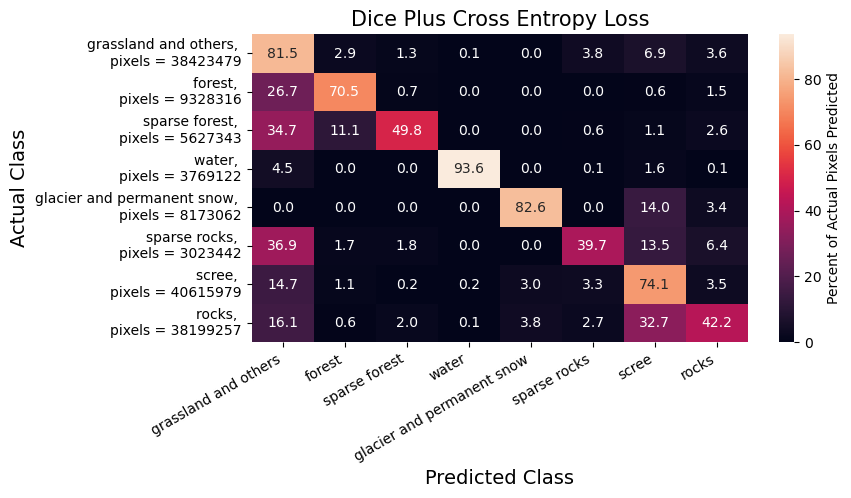

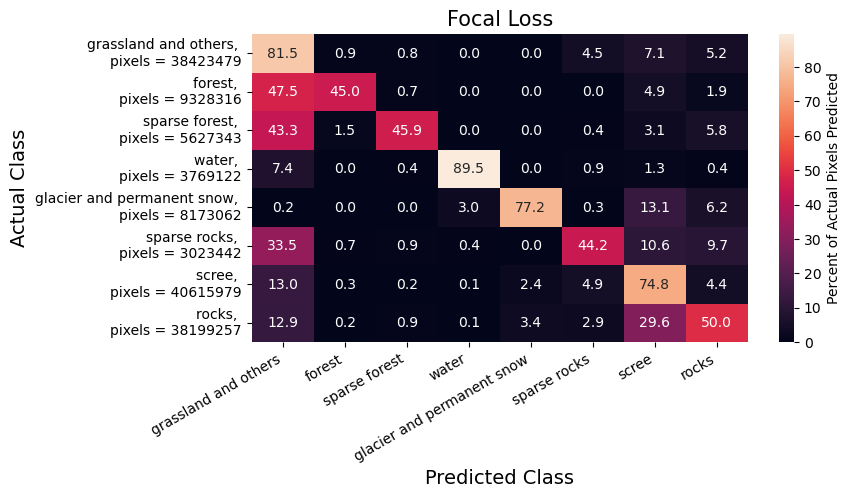

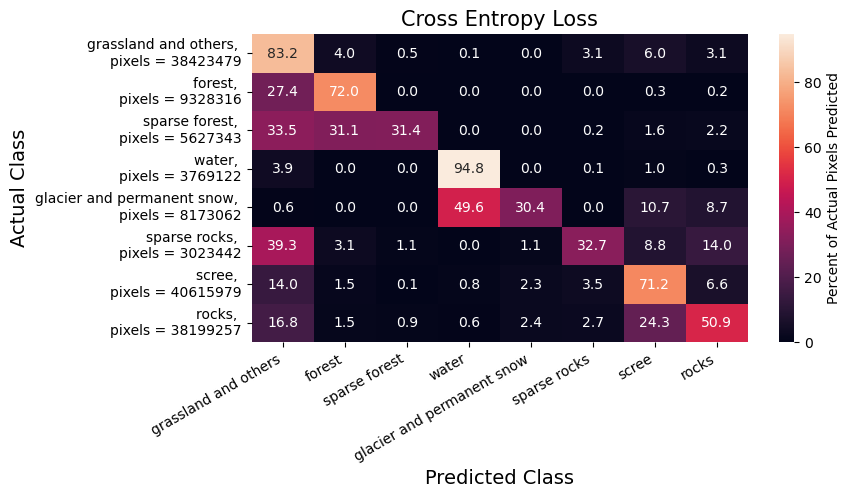

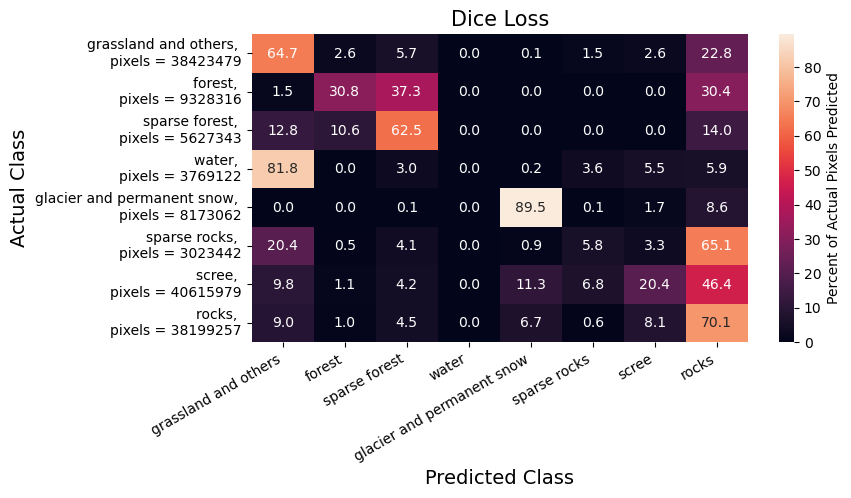

In [51]:
heat_dc = dice_mtrx.copy()
heat_dc_ce = dice_ce_mtrx.copy()
heat_focal = focal_mtrx.copy()
heat_ce = ce_mtrx.copy()
heat_mat = [heat_dc_ce, heat_focal, heat_ce, heat_dc]
titles = ['Dice Plus Cross Entropy Loss', 'Focal Loss', 'Cross Entropy Loss', 'Dice Loss']
for df in heat_mat:
    df['total'] = df.sum(axis=1)
    for col in df.drop('total', axis=1).columns:
        df[col] = (df[col]/df.total)*100
    
    df.reset_index(inplace=True)
    #df.actual = df.actual.apply(lambda x: x +'\nn= ')
    df.actual = df.apply(lambda x: x.actual + ', \npixels = ' + str(x.total), axis=1)
    df.drop('total', axis=1, inplace=True)
    df.set_index('actual', inplace=True)

for df, title in zip(heat_mat, titles):
    totals = df.sum(axis=1).tolist()
    plt.figure(figsize=(8,4))
    sns.heatmap(df, annot=True, fmt='.1f',cbar_kws={'label': 'Percent of Actual Pixels Predicted'})
    plt.ylabel('Actual Class', size=14)
    plt.xlabel('Predicted Class',size=14)
    plt.xticks(rotation=30, ha='right')
    plt.title(title, size=15)
    plt.savefig(f'./heat_maps/{title}_heat_map.pdf', format= 'pdf', dpi=500, bbox_inches='tight')


We are going to do a little bit of plotting here

Index(['Step', 'PSPNet/ce - train_dice_score', 'PSPNet/ce - valid_dice_score',
       'PSPNet/focal/2 - train_dice_score',
       'PSPNet/focal/2 - valid_dice_score',
       'PSPNet/dice+ce - train_dice_score',
       'PSPNet/dice+ce - valid_dice_score', 'PSPNet/dice - train_dice_score',
       'PSPNet/dice - valid_dice_score'],
      dtype='object')


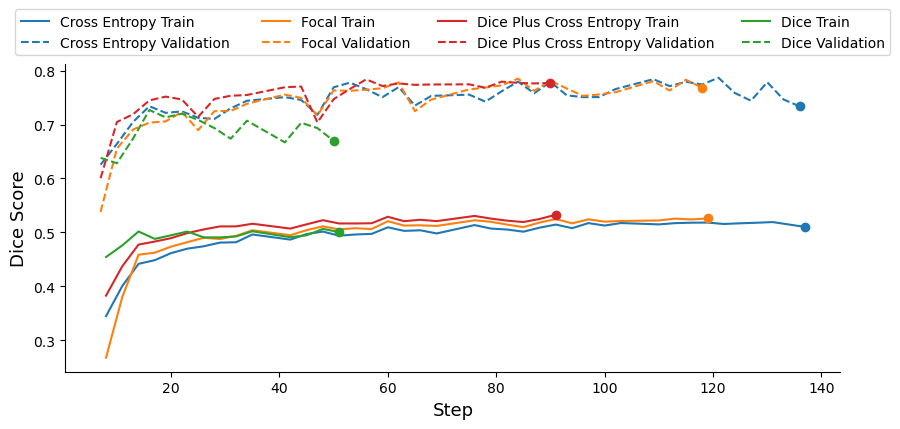

In [104]:
train_val = pd.read_csv('./csv/wandb_export_2023-01-15T00_27_11.534+01_00.csv')
for col in train_val.columns:
    if col.endswith('MIN') or col.endswith('MAX'):
        train_val.drop(col, axis=1, inplace =True)

print(train_val.columns)

mapper = {
    'PSPNet/ce - train_dice_score': 'Cross Entropy Train',
    'PSPNet/ce - valid_dice_score': 'Cross Entropy Validation ',
    'PSPNet/focal/2 - train_dice_score': 'Focal Train',
    'PSPNet/focal/2 - valid_dice_score': 'Focal Validation',
    'PSPNet/dice+ce - train_dice_score': 'Dice Plus Cross Entropy Train',
    'PSPNet/dice+ce - valid_dice_score': 'Dice Plus Cross Entropy Validation', 
    'PSPNet/dice - train_dice_score': 'Dice Train',
    'PSPNet/dice - valid_dice_score': 'Dice Validation'
}
train_val.rename(mapper, axis=1, inplace=True)
cmap = plt.get_cmap("tab10")
plt.figure(figsize=(10,4))
ax = plt.axes()
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
for col in train_val.drop('Step', axis=1):
    if col.startswith('Cross'):
        clr = cmap(0)
    elif col.startswith('Focal'):
        clr = cmap(1)
    elif col.startswith('Dice Plus'):
        clr = cmap(3)
    else:
        clr = cmap(2)

    if col.endswith('Train'):
        line_type = '-'
    else:
        line_type = '--'
    temp_df = train_val[['Step', col]].dropna()
    plt.plot(temp_df.Step, temp_df[col], line_type,color=clr, label=col)
    plt.plot(temp_df.loc[temp_df.Step == temp_df.Step.max()].Step, 
                temp_df.loc[temp_df.Step == temp_df.Step.max()][col], 'o', color=clr)
plt.legend(loc='upper center', ncol=4, bbox_to_anchor = (0.5, 1.2))
plt.ylabel('Dice Score', size=13)
plt.xlabel('Step', size = 13)
plt.savefig('./Train and validation dice score.pdf',format= 'pdf', dpi=500,  bbox_inches='tight')
